<a href="https://colab.research.google.com/github/sim-so/HandsOnML/blob/main/14_CNN_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14 CNN 연습문제

## 9. 나만의 CNN으로 MNIST 해결하기
최고 성능이 99.91인 SOTA 모델을 만들어보자. >
[Paper](https://paperswithcode.com/paper/an-ensemble-of-simple-convolutional-neural)
- 단순 CNN 모델
    - 매 Conv Layer마다 BatchNormalization
    - 3개 모델의 kernel size를 각 3, 5, 7로
- 데이터 증강
- 모델 앙상블

### Load Dataset

In [ ]:
!python -m pip install tensorflow-gpu==2.8.3

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from functools import partial

keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

In [1]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("mnist", as_supervised=True, with_info=True)

In [2]:
info.splits

{'test': <SplitInfo num_examples=10000, num_shards=1>,
 'train': <SplitInfo num_examples=60000, num_shards=1>}

In [3]:
info.features["label"].names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [4]:
info.features["label"].num_classes

10

In [5]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "mnist", split=["test", "train[50000:]", "train[:50000]"],
    as_supervised=True)

### Preprocessing
- [0, 255]의 숫자를 [-1, 1] 범위로 normalization
- 데이터 증강하여 Train set으로 사용
    - 시계방향 혹은 반시계방향으로 20도 회전
    - 상하좌우 중 임의의 방향으로 20% 이동
- Training 중 새로 변형하여 매 epoch 마다 새로운 데이터를 학습하게 함

In [8]:
keras.backend.clear_session()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import RandomRotation

def normalize(image):
    return image * 2 / 255 - 1

def preprocess(image, label, randomize=False, preprocessor=None):
    image = normalize(image)
    if randomize:
        image = preprocessor(image, training=True)
    return image, label

transforms = Sequential(name="transforms_near_near")
transforms.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="nearest"))    # 20%
transforms.add(RandomRotation(0.06, fill_mode="nearest", interpolation="nearest"))           # almost 20 degree
transforms.compile()

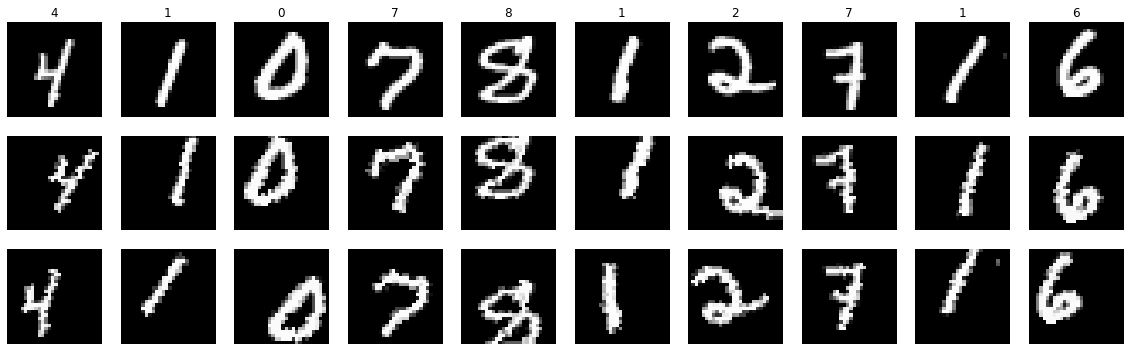

In [10]:
n_samples = 10
plt.figure(figsize=(20, 8))
for i, (image, label) in enumerate(train_set_raw.take(n_samples), 1):
    plt.subplot(4, n_samples, i)
    plt.imshow(image.numpy().squeeze(-1), cmap="gray")
    plt.title(f"{label}")
    plt.axis("off")
for i in range(1, 3):
    for j, (image, label) in enumerate(train_set_raw.take(n_samples).map(partial(preprocess, randomize=True, preprocessor=transforms)), 1):
        plt.subplot(4, n_samples, 10*i+j)
        plt.imshow(image.numpy().squeeze(-1), cmap="gray")
        plt.axis("off")
plt.show()

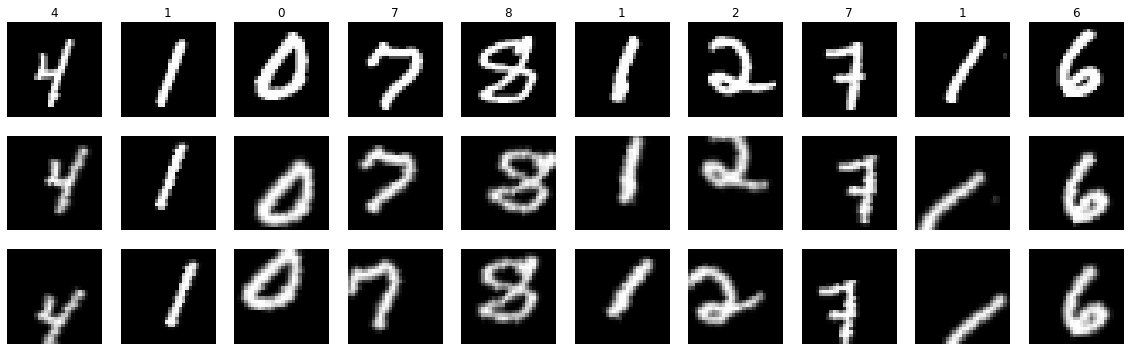

In [11]:
transforms = Sequential(name="transforms_bi_bi")
transforms.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="bilinear"))    # 20%
transforms.add(RandomRotation(0.06, fill_mode="nearest", interpolation="bilinear"))           # almost 20 degree
transforms.compile()

n_samples = 10
plt.figure(figsize=(20, 8))
for i, (image, label) in enumerate(train_set_raw.take(n_samples), 1):
    plt.subplot(4, n_samples, i)
    plt.imshow(image.numpy().squeeze(-1), cmap="gray")
    plt.title(f"{label}")
    plt.axis("off")
for i in range(1, 3):
    for j, (image, label) in enumerate(train_set_raw.take(n_samples).map(partial(preprocess, randomize=True, preprocessor=transforms)), 1):
        plt.subplot(4, n_samples, 10*i+j)
        plt.imshow(image.numpy().squeeze(-1), cmap="gray")
        plt.axis("off")
plt.show()

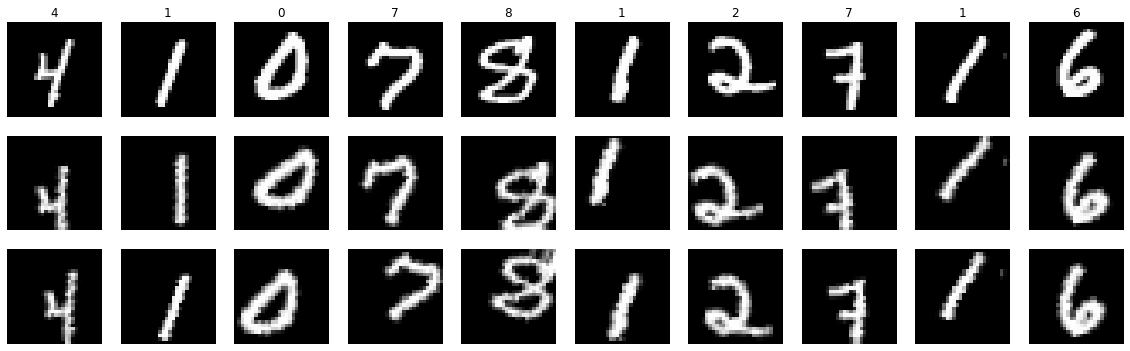

In [12]:
transforms = Sequential(name="transforms_near_bi")
transforms.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="nearest"))    # 20%
transforms.add(RandomRotation(0.06, fill_mode="nearest", interpolation="bilinear"))           # almost 20 degree
transforms.compile()

n_samples = 10
plt.figure(figsize=(20, 8))
for i, (image, label) in enumerate(train_set_raw.take(n_samples), 1):
    plt.subplot(4, n_samples, i)
    plt.imshow(image.numpy().squeeze(-1), cmap="gray")
    plt.title(f"{label}")
    plt.axis("off")
for i in range(1, 3):
    for j, (image, label) in enumerate(train_set_raw.take(n_samples).map(partial(preprocess, randomize=True, preprocessor=transforms)), 1):
        plt.subplot(4, n_samples, 10*i+j)
        plt.imshow(image.numpy().squeeze(-1), cmap="gray")
        plt.axis("off")
plt.show()

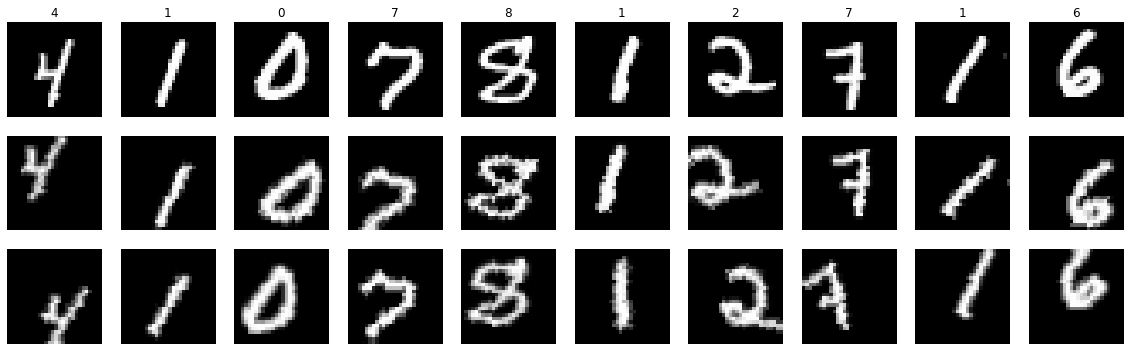

In [13]:
transforms = Sequential(name="transforms_bi_near")
transforms.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="bilinear"))    # 20%
transforms.add(RandomRotation(0.06, fill_mode="nearest", interpolation="nearest"))           # almost 20 degree
transforms.compile()

n_samples = 10
plt.figure(figsize=(20, 8))
for i, (image, label) in enumerate(train_set_raw.take(n_samples), 1):
    plt.subplot(4, n_samples, i)
    plt.imshow(image.numpy().squeeze(-1), cmap="gray")
    plt.title(f"{label}")
    plt.axis("off")
for i in range(1, 3):
    for j, (image, label) in enumerate(train_set_raw.take(n_samples).map(partial(preprocess, randomize=True, preprocessor=transforms)), 1):
        plt.subplot(4, n_samples, 10*i+j)
        plt.imshow(image.numpy().squeeze(-1), cmap="gray")
        plt.axis("off")
plt.show()

### Modeling

In [14]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import InputLayer

keras.backend.clear_session()
np.random.seed(33)
tf.random.set_seed(33)

#### M3

In [15]:
# M3
model_M3 = Sequential(name="M3")
model_M3.add(InputLayer((28, 28, 1)))
model_M3.add(Conv2D(filters=32,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=48,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=64,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=80,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=96,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=112, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=144, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=160, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=176, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Flatten())
model_M3.add(Dense(units=10))
model_M3.add(BatchNormalization())
model_M3.add(Softmax())

In [16]:
model_M3.summary()

Model: "M3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 48)        13872     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 48)       192       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        27712     
                                                                 
 batch_normalization_2 (Batc  (None, 22, 22, 64)       256      

#### M5

In [17]:
model_M5 = Sequential(name="M5")
model_M5.add(InputLayer((28, 28, 1)))
model_M5.add(Conv2D(filters=32,  kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Conv2D(filters=64,  kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Conv2D(filters=96,  kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Conv2D(filters=128, kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Conv2D(filters=160, kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Flatten())
model_M5.add(Dense(units=10))
model_M5.add(BatchNormalization())
model_M5.add(Softmax())

In [18]:
model_M5.summary()

Model: "M5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 batch_normalization_11 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 batch_normalization_12 (Bat  (None, 20, 20, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 96)        153696    
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 96)       384      

#### M7

In [19]:
# M7
model_M7 = Sequential(name="M7")
model_M7.add(InputLayer((28, 28, 1)))
model_M7.add(Conv2D(filters=48,  kernel_size=7, activation="relu"))
model_M7.add(BatchNormalization())
model_M7.add(Conv2D(filters=96,  kernel_size=7, activation="relu"))
model_M7.add(BatchNormalization())
model_M7.add(Conv2D(filters=144, kernel_size=7, activation="relu"))
model_M7.add(BatchNormalization())
model_M7.add(Conv2D(filters=192, kernel_size=7, activation="relu"))
model_M7.add(BatchNormalization())
model_M7.add(Flatten())
model_M7.add(Dense(units=10))
model_M7.add(BatchNormalization())
model_M7.add(Softmax())

In [20]:
model_M7.summary()

Model: "M7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 22, 22, 48)        2400      
                                                                 
 batch_normalization_17 (Bat  (None, 22, 22, 48)       192       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 96)        225888    
                                                                 
 batch_normalization_18 (Bat  (None, 16, 16, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 10, 10, 144)       677520    
                                                                 
 batch_normalization_19 (Bat  (None, 10, 10, 144)      576      

### Training
- transform 층을 모델 앞에 붙여 학습 진행 (evalution 시에는 transform 하지 않음)
- Hyperparameter
    - batch size = training 120, validation 100
    - initial learning_rate = 0.001
    - decay (beta_1) = 0.98
    - exponential moving average of weights
        - exponential decay = 0.999

In [21]:
transforms = Sequential(name="transforms_near_bi")
transforms.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="nearest"))    # 20%
transforms.add(RandomRotation(0.06, fill_mode="nearest", interpolation="bilinear"))           # almost 20 degree
transforms.compile()

n_epochs = 150
train_batch_size = 120
valid_batch_size = 100
train_set = train_set_raw.shuffle(10000)
train_set = train_set.map(partial(preprocess, randomize=True, preprocessor=transforms), num_parallel_calls=100).batch(train_batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(valid_batch_size, num_parallel_calls=100).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(valid_batch_size, num_parallel_calls=100).prefetch(1)

In [22]:
model_history = dict()

In [23]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.98)
model_M3.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy", 
                metrics=["accuracy"])
history_M3 = model_M3.fit(train_set, 
                          epochs=n_epochs,
                          batch_size=train_batch_size,
                          shuffle=True,
                          validation_data=valid_set,
                          validation_batch_size=valid_batch_size
                          )
model_history["M3"] = history_M3.history
model_M3.evaluate(test_set)

Epoch 1/150
417/417 [==============================] - 33s 48ms/step - loss: 0.7416 - accuracy: 0.8295 - val_loss: 1.3614 - val_accuracy: 0.5525
Epoch 2/150
417/417 [==============================] - 18s 44ms/step - loss: 0.2590 - accuracy: 0.9601 - val_loss: 0.1973 - val_accuracy: 0.9677
Epoch 3/150
417/417 [==============================] - 19s 45ms/step - loss: 0.1746 - accuracy: 0.9683 - val_loss: 0.4954 - val_accuracy: 0.8603
Epoch 4/150
417/417 [==============================] - 19s 46ms/step - loss: 0.1336 - accuracy: 0.9741 - val_loss: 0.1458 - val_accuracy: 0.9701
Epoch 5/150
417/417 [==============================] - 19s 45ms/step - loss: 0.1185 - accuracy: 0.9740 - val_loss: 0.2415 - val_accuracy: 0.9413
Epoch 6/150
417/417 [==============================] - 19s 45ms/step - loss: 0.0986 - accuracy: 0.9781 - val_loss: 0.0779 - val_accuracy: 0.9839
Epoch 7/150
417/417 [==============================] - 19s 46ms/step - loss: 0.0872 - accuracy: 0.9793 - val_loss: 0.0700 - val_ac

[0.026043463498353958, 0.9939000010490417]

In [24]:
history_M3.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
model_M5.compile(optimizer=optimizer,
                 loss="sparse_categorical_crossentropy", 
                 metrics=["accuracy"])
history_M5 = model_M5.fit(train_set, 
                          epochs=n_epochs,
                          batch_size=train_batch_size,
                          shuffle=True,
                          validation_data=valid_set,
                          validation_batch_size=valid_batch_size
                          )
model_history["M5"] = history_M5.history
model_M5.evaluate(test_set)

Epoch 1/150
417/417 [==============================] - 16s 36ms/step - loss: 0.6103 - accuracy: 0.8545 - val_loss: 3.6843 - val_accuracy: 0.1723
Epoch 2/150
417/417 [==============================] - 14s 33ms/step - loss: 0.1988 - accuracy: 0.9606 - val_loss: 0.1187 - val_accuracy: 0.9785
Epoch 3/150
417/417 [==============================] - 14s 34ms/step - loss: 0.1369 - accuracy: 0.9705 - val_loss: 0.1483 - val_accuracy: 0.9758
Epoch 4/150
417/417 [==============================] - 14s 33ms/step - loss: 0.1043 - accuracy: 0.9770 - val_loss: 1.2791 - val_accuracy: 0.7407
Epoch 5/150
417/417 [==============================] - 14s 33ms/step - loss: 0.0897 - accuracy: 0.9791 - val_loss: 0.6088 - val_accuracy: 0.8230
Epoch 6/150
417/417 [==============================] - 14s 33ms/step - loss: 0.0826 - accuracy: 0.9805 - val_loss: 0.0733 - val_accuracy: 0.9804
Epoch 7/150
417/417 [==============================] - 14s 34ms/step - loss: 0.0742 - accuracy: 0.9809 - val_loss: 0.5788 - val_ac

[0.03342532366514206, 0.9929999709129333]

In [26]:
model_M7.compile(optimizer=optimizer,
                 loss="sparse_categorical_crossentropy", 
                 metrics=["accuracy"])
history_M7 = model_M7.fit(train_set, 
                          epochs=n_epochs,
                          batch_size=train_batch_size,
                          shuffle=True,
                          validation_data=valid_set,
                          validation_batch_size=valid_batch_size
                          )
model_history["M7"] = history_M7.history
model_M7.evaluate(test_set)

Epoch 1/150
417/417 [==============================] - 16s 36ms/step - loss: 0.6712 - accuracy: 0.8268 - val_loss: 0.3812 - val_accuracy: 0.9000
Epoch 2/150
417/417 [==============================] - 15s 35ms/step - loss: 0.2311 - accuracy: 0.9468 - val_loss: 0.1749 - val_accuracy: 0.9615
Epoch 3/150
417/417 [==============================] - 15s 35ms/step - loss: 0.1573 - accuracy: 0.9629 - val_loss: 0.6010 - val_accuracy: 0.8233
Epoch 4/150
417/417 [==============================] - 15s 35ms/step - loss: 0.1270 - accuracy: 0.9692 - val_loss: 0.4162 - val_accuracy: 0.8914
Epoch 5/150
417/417 [==============================] - 14s 34ms/step - loss: 0.1092 - accuracy: 0.9719 - val_loss: 0.1469 - val_accuracy: 0.9638
Epoch 6/150
417/417 [==============================] - 15s 35ms/step - loss: 0.0954 - accuracy: 0.9757 - val_loss: 0.1071 - val_accuracy: 0.9740
Epoch 7/150
417/417 [==============================] - 14s 34ms/step - loss: 0.0846 - accuracy: 0.9782 - val_loss: 0.0996 - val_ac

[0.02696540206670761, 0.9914000034332275]

### Experiments

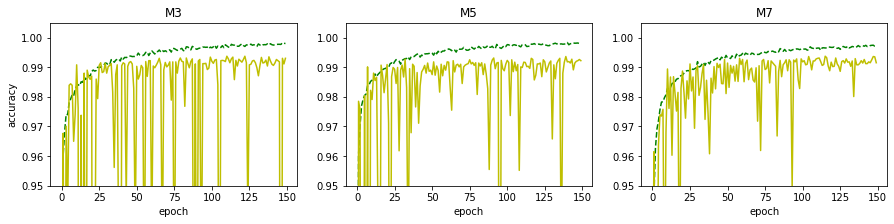

In [28]:
fig = plt.figure(figsize=(15, 3))
for i, (model_name, history) in enumerate(model_history.items()):
    plt.subplot(1, 3, i+1)
    plt.plot(history["accuracy"], "g--", label="training")
    plt.plot(history["val_accuracy"], "y-", label="validation")
    plt.xlabel("epoch")
    if i == 0:
        plt.ylabel("accuracy")
    else:
        plt.ylabel("")
    plt.title(f"{model_name}")
    plt.ylim(0.95, 1.005)
plt.show()

### Ensemble
- 논문에서는 initial weights를 다르게 해서 각 모델별로 1000개씩, 총 3000개를 학습시키고 앙상블 하여 최고 성적을 달성
- (모델링에 대한 실험에서는 10개씩 총 30개로)
- 여기서는 3개 모델에 대해서만 앙상블 해보기로
    - 단 3개의 모델이지만 accuracy 상승 (0.9965)



In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

test_set, valid_set, train_set = tfds.load(
    "mnist", split=["test", "train[50000:]", "train[:50000]"],
    as_supervised=True)
train_set = train_set.shuffle(len(train_set))

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label]))
            }))

In [4]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\014\022\002\010\034\022\002\010\034\022\002\010\001\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\n\200\260\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000U\374\347\023\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\0009\363\375T\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\341\375\205\000\0

In [5]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [6]:
train_filepaths = write_tfrecords("my_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_mnist.test", test_set)

In [7]:
from functools import partial

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import RandomRotation

transforms = Sequential([
    RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="nearest"),
    RandomRotation(0.06, fill_mode="nearest", interpolation="bilinear")
    ])
transforms.compile()

def normalize(image):
    return image * 2 / 255 - 1

def preprocess(tfrecord, training=False):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28, 1])
    image = normalize(image)
    image = transforms(image, training=training)
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, randomize=False, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(partial(preprocess, training=randomize), num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [8]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=50000, batch_size=150, randomize=True)
valid_set = mnist_dataset(valid_filepaths, batch_size=100)
test_set = mnist_dataset(test_filepaths, batch_size=100)

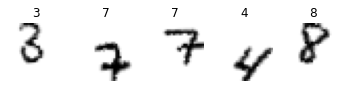

In [9]:
import matplotlib.pyplot as plt

for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.optimizers import Adam

import gc

def set_exps(random_seed):
    keras.backend.clear_session()
    np.random.seed(33)
    tf.random.set_seed(33)

def build_model(name):
    kernel_size, n_layers, filters_start, filters_step = model_params[name]
    model = Sequential(name=name)
    model.add(InputLayer((28, 28, 1)))
    for i in range(n_layers):
        model.add(Conv2D(filters=filters_start + i * filters_step, kernel_size=kernel_size, activation="relu"))
        model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units=10))
    model.add(BatchNormalization())
    model.add(Softmax())
    model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.98),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [11]:
from sklearn.metrics import accuracy_score
def ensemble_preds(preds, voting_mode="soft"):
    return np.mean([v for k, v in preds.items()], axis=0).argmax(axis=-1)

In [12]:
y_test = np.concatenate([y for x, y in test_set], axis=0)
len(y_test)

10000

In [13]:
model_params = {
        "M3": (3, 10, 32, 16),
        "M5": (5, 5, 32, 32),
        "M7": (7, 4, 48, 48),
    }
n_models = 3
random_seed = 33
# models = dict()
preds = dict()
scores = []

for i in range(n_models):
    for model_name in model_params.keys():
        set_exps(random_seed+i)
        model = build_model(model_name)
        history = model.fit(train_set,
                        epochs=100,
                        batch_size=150,
                        shuffle=True,
                        validation_data=valid_set,
                        validation_batch_size=100,
                        verbose=1)
        model.evaluate(test_set)
        pred = model.predict(test_set)
        # models[f"{model_name}_{random_seed+i}"] = model
        preds[f"{model_name}_{random_seed+i}"] = pred
        del model, history
        gc.collect()
    score = accuracy_score(y_test, ensemble_preds(preds))
    print("Ensemble {} models : {:4f}".format(i+1, score))
    scores.append(score)

Epoch 1/100
334/334 [==============================] - 38s 81ms/step - loss: 0.8072 - accuracy: 0.8095 - val_loss: 4.2745 - val_accuracy: 0.1537
Epoch 2/100
334/334 [==============================] - 26s 79ms/step - loss: 0.2812 - accuracy: 0.9586 - val_loss: 0.3248 - val_accuracy: 0.9255
Epoch 3/100
334/334 [==============================] - 26s 78ms/step - loss: 0.1858 - accuracy: 0.9696 - val_loss: 0.2326 - val_accuracy: 0.9629
Epoch 4/100
334/334 [==============================] - 26s 78ms/step - loss: 0.1408 - accuracy: 0.9750 - val_loss: 0.0997 - val_accuracy: 0.9769
Epoch 5/100
334/334 [==============================] - 26s 78ms/step - loss: 0.1191 - accuracy: 0.9758 - val_loss: 0.0960 - val_accuracy: 0.9822
Epoch 6/100
334/334 [==============================] - 26s 78ms/step - loss: 0.0966 - accuracy: 0.9800 - val_loss: 0.1676 - val_accuracy: 0.9583
Epoch 7/100
334/334 [==============================] - 26s 77ms/step - loss: 0.0944 - accuracy: 0.9791 - val_loss: 0.1023 - val_ac

In [14]:
for i, score in enumerate(scores):
    print("Ensemble {} models : {:4f}".format(i+1, score))

Ensemble 1 models : 0.995400
Ensemble 2 models : 0.996300
Ensemble 3 models : 0.996300


## 10. 전이 학습을 사용한 대규모 이미지 분류

In [ ]:
!python -m pip install tensorflow-gpu==2.8.3

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

np.random.seed(33)
tf.random.set_seed(33)

test_set, valid_set, train_set = tfds.load(
    'imagenette/320px-v2', split=["validation[50%:]", "validation[:50%]", "train"], 
    as_supervised=True)
train_set = train_set.shuffle(len(train_set))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px-v2/1.0.0.incompleteNNRT5G/imagenette-train.tfrecord*...: …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px-v2/1.0.0.incompleteNNRT5G/imagenette-validation.tfrecord*…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/320px-v2/1.0.0. Subsequent calls will reuse this data.


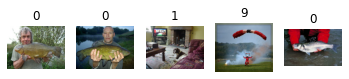

In [3]:
import matplotlib.pyplot as plt

for i, (X, y) in enumerate(train_set.take(5)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X.numpy())
    plt.axis("off")
    plt.title(str(y.numpy()))

In [4]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

def create_example(image, label):
    image_data = tf.io.encode_jpeg(image)
    # image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label]))
            }))

In [5]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [6]:
train_filepaths = write_tfrecords("my_imagenette.train", train_set)
valid_filepaths = write_tfrecords("my_imagenette.valid", valid_set)
test_filepaths = write_tfrecords("my_imagenette.test", test_set)

In [7]:
from functools import partial

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(tfrecord, randomize=False):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    # image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.io.decode_jpeg(example["image"])
    image = tf.image.resize(image, [320, 320])
    image = tf.cast(image, tf.float32)
    if randomize:
        image = random_crop(image)
    image = keras.applications.xception.preprocess_input(image)
    return image, example["label"]

def my_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, randomize=False, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(partial(preprocess, randomize=randomize), num_parallel_calls=n_parse_threads)
    if randomize:
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [8]:
train_set = my_dataset(train_filepaths, shuffle_buffer_size=10000, batch_size=32, randomize=True)
valid_set = my_dataset(valid_filepaths, batch_size=32)
test_set = my_dataset(test_filepaths, batch_size=32)

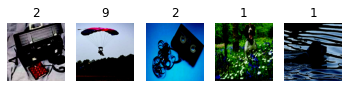

In [9]:
import matplotlib.pyplot as plt

for X, y in train_set.take(1):
    for i in range(5):
        x = X[i].numpy()
        plt.subplot(1, 5, i + 1)
        plt.imshow(x)
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import gc

base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(10, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

83697664/83683744 [==============================] - 0s 0us/step
0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_ac

In [11]:
for layer in base_model.layers:
    layer.trainable = False

dataset_size, batch_size = 9469, 32
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
221/221 [==============================] - 81s 318ms/step - loss: 0.0549 - accuracy: 0.9843 - val_loss: 0.0152 - val_accuracy: 0.9943
Epoch 2/5
221/221 [==============================] - 68s 310ms/step - loss: 0.0082 - accuracy: 0.9972 - val_loss: 0.0050 - val_accuracy: 0.9986
Epoch 3/5
221/221 [==============================] - 69s 312ms/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.0092 - val_accuracy: 0.9964
Epoch 4/5
221/221 [==============================] - 69s 312ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.0076 - val_accuracy: 0.9979
Epoch 5/5
221/221 [==============================] - 69s 313ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0044 - val_accuracy: 0.9979


In [13]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
221/221 [==============================] - 254s 1s/step - loss: 0.0310 - accuracy: 0.9898 - val_loss: 0.0238 - val_accuracy: 0.9943
Epoch 2/40
221/221 [==============================] - 245s 1s/step - loss: 0.0198 - accuracy: 0.9945 - val_loss: 0.0176 - val_accuracy: 0.9950
Epoch 3/40
221/221 [==============================] - 245s 1s/step - loss: 0.0127 - accuracy: 0.9953 - val_loss: 0.0252 - val_accuracy: 0.9950
Epoch 4/40
221/221 [==============================] - 246s 1s/step - loss: 0.0104 - accuracy: 0.9973 - val_loss: 0.0112 - val_accuracy: 0.9972
Epoch 5/40
221/221 [==============================] - 245s 1s/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0059 - val_accuracy: 0.9986
Epoch 6/40
221/221 [==============================] - 245s 1s/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0052 - val_accuracy: 0.9986
Epoch 7/40
221/221 [==============================] - 245s 1s/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0079 - val_accuracy: 0.9979

In [14]:
pred = model.predict(test_set)

In [18]:
pred = pred.argmax(axis=-1)

In [19]:
from sklearn.metrics import accuracy_score

y_test = np.concatenate([y for x, y in test_set], axis=0)
len(y_test)

1963

In [20]:
accuracy_score(y_test, pred)

0.9959246051961284